In [1]:
import pandas as pd
from numpy import array, median, sqrt
from hw import Jamshidian as jamsh
from hw import Henrard as henr
from hw import hw_helper
from hw import calibration as hw_calib
from hw.const import *
from fox_toolbox.utils import xml_parser, rates, volatility
from random import choice
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (12, 8.)})
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

### Read IRSM FORM

In [2]:
main_curve, sprds = xml_parser.get_rate_curves(INPUT_5SWO)
dsc_curve = main_curve

try:
    estim_curve = sprds[0]
except TypeError:
    estim_curve = main_curve

cal_basket = list(xml_parser.get_calib_basket(INPUT_5SWO))

### READ IRSM OUT

In [3]:
_, irsmout = xml_parser.get_xml(OUTPUT_5SWO)
ref_swos = list(xml_parser.get_calib_basket(irsmout))

hw_params = xml_parser.get_hw_params(irsmout)
ref_mr = hw_params.meanR
ref_sigmas = hw_params.hw_volatility

### Jamshidian pricer with ref sigma (Hernard)

In [4]:
calib_premiumsJ = []
debug_df = pd.DataFrame()

for swo in cal_basket:
      
    jamsh_price, debug = jamsh.hw_swo(swo, ref_mr, ref_sigmas, dsc_curve, estim_curve)
    debug_df = pd.concat([debug_df, pd.DataFrame(data=debug)], sort=False)
    calib_premiumsJ.append(jamsh_price)
    
REFJ = array([0.01495868953561849, 0.017290668443338708, 0.015277326631131571, 0.009790960001713978])
print('all is ok') if max(REFJ - array(calib_premiumsJ)) < 1e-14 else print('Unexpected error')

all is ok


## Hernard pricer with its ref sigma

In [5]:
calib_premiumsH = []

for swo in cal_basket:
      
    henr_price, debug = henr.hw_swo(swo, ref_mr, ref_sigmas, dsc_curve, estim_curve)
    debug_df = pd.concat([debug_df, pd.DataFrame(data=debug)], sort=False)
    calib_premiumsH.append(henr_price)

REFH = array([0.01493072285045029, 0.017218357816201957, 0.015144105523752116, 0.009647051056191125])
print('all is ok') if max(REFH - array(calib_premiumsH)) < 1e-14 else print('Unexpected error')

all is ok


In [6]:
pd.pivot_table(debug_df, values=['total_var'], index=['Expiry'], columns=[], aggfunc=median).T

Expiry,0.9972602739726,2.0,2.9972602739726,3.9972602739726
total_var,0.000004,0.00002,0.000051,0.000126


## HW Calibration

In [7]:
sigma_hw_jamsh, debug_J = hw_calib.calibrate_sigma_hw(cal_basket, ref_mr, dsc_curve, estim_curve, IsJamsh=True)
sigma_hw_jamsh

AAAA 0.8411999569050503
AAAA 0.8137515310418304
AAAA 0.7713882561119677
AAAA 0.7321810568189532


Curve(array([ 0.        ,  0.99726027,  2.        ,  2.99726027,  3.99726027,
       33.99726027]), array([0.00165585, 0.00165585, 0.00355701, 0.00462183, 0.0067773 ,
       0.0067773 ]), 'PieceWise', 'HW model sigma Jamshidian')

In [8]:
sigma_hw_henr, debug_H = hw_calib.calibrate_sigma_hw(cal_basket, ref_mr, dsc_curve, estim_curve, IsJamsh=False)
sigma_hw_henr

AAAA 0.8411999569050503
AAAA 0.8137515310418304
AAAA 0.7713882561119677
AAAA 0.7321810568189532


Curve(array([ 0.        ,  0.99726027,  2.        ,  2.99726027,  3.99726027,
       33.99726027]), array([0.00195427, 0.00195427, 0.00366332, 0.00496463, 0.00726417,
       0.00726417]), 'PieceWise', 'HW model sigma Henrard')

Sigma diff recon : [-8.62644092e-06 -8.62644092e-06  4.16406928e-06 -1.16426686e-08
 -1.75553318e-08 -1.75553318e-08]


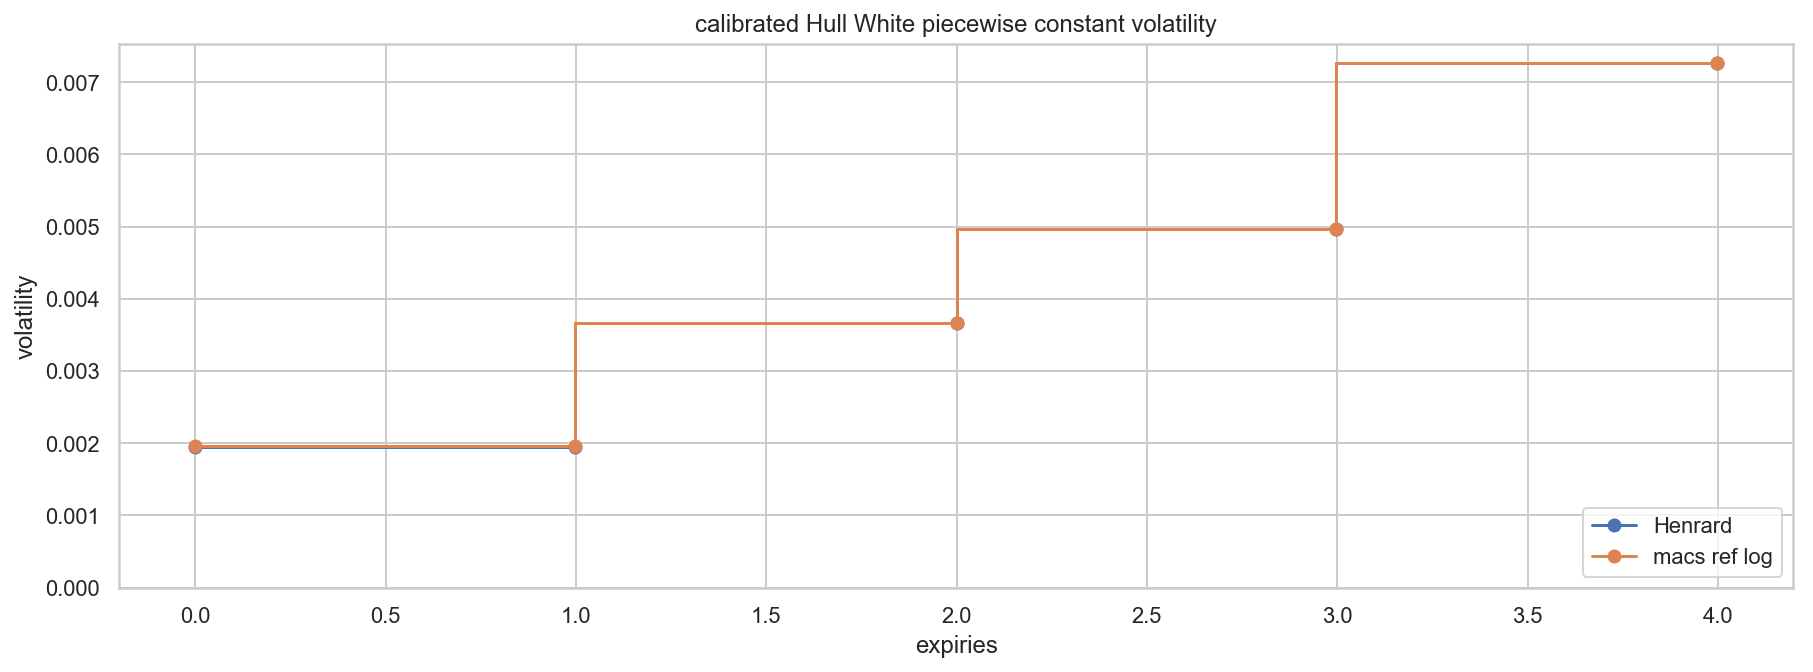

In [9]:
plt.figure(figsize=(15,5));

# plt.step(sigma_hw_jamsh.buckets, sigma_hw_jamsh.values, label = 'Jamshidian', marker='o', where='post')
plt.step(sigma_hw_henr.buckets[:-1],   sigma_hw_henr.values[:-1],   label = 'Henrard', marker='o', where='pre');
plt.step(ref_sigmas.buckets[:-1], ref_sigmas.values[:-1], label = 'macs ref log', marker='o', where='pre');

plt.ylim(0);
plt.legend(loc='lower right');
plt.title('calibrated Hull White piecewise constant volatility');
plt.xlabel('expiries');
plt.ylabel('volatility');

print('Sigma diff recon :', sigma_hw_henr.values - ref_sigmas.values)

### Schrager to Market mistmatch

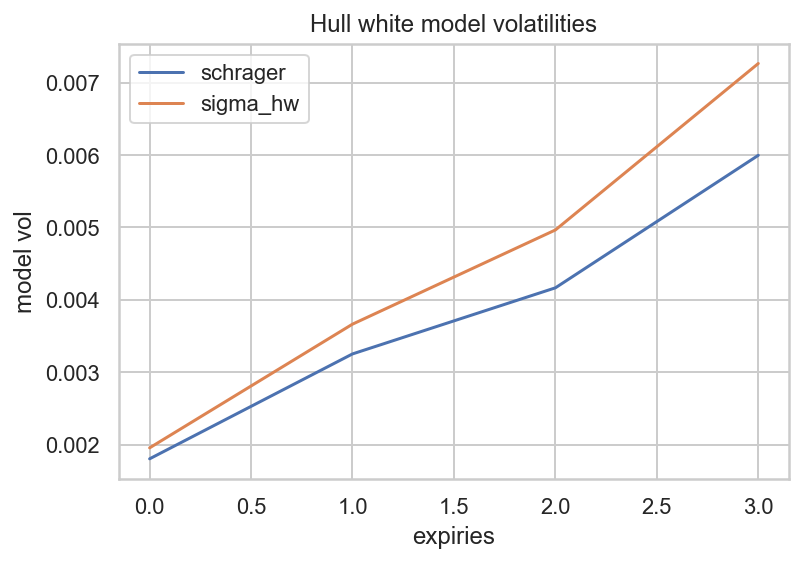

In [14]:
plt.plot(debug_H['schragerv0'], label='schrager')
plt.plot(debug_H['sigma_hw'], label='sigma_hw')

plt.title('Hull white model volatilities')
plt.legend();plt.xlabel('expiries');plt.ylabel('model vol');

$\text{Variance}_{Mkt}^{T_{exp}} = \sigma_M^2 * T_{exp}$

<br> $\text{Variance}_{HW}^{T_{exp}} \approx C(a)^2 * V(T_{exp})$

<br>$V(T_{exp}) = V(T_{exp-1}) + \sigma_{i}^2(T_{exp}) * \frac{e^{2 a \mathcal{J}_{i}}-e^{2 a \mathcal{T}_{i-1}}}{2 a}$

<br>$\text{Variance}_{HW}^{T_{exp}} = \text{Variance}_{HW}^{T_{exp-1}} + C(a)^2 * \boxed{\sigma_{Schrager}^2(T_{exp})} * \frac{e^{2 a \mathcal{J}_{i}}-e^{2 a \mathcal{T}_{i-1}}}{2 a} = \text{Variance}_{Mkt}^{T_{exp}}$

<br>$ \text{Variance}_{Mkt}^{T_{exp}} = C(a)^2 * \sigma_{Uncond Schrager}^2(T_{exp}) * \frac{e^{2 a \mathcal{J}_{i}}-e^{2 a \mathcal{T}_{i-1}}}{2 a}  $

# Schrager pricing

$S_T \sim N \Big(F_0,\  C(a)^2 V(T_{exp}) \Big) $

<br>$ V(T)=\int_{0}^{T} \sigma^{2}(s) e^{2 a s} d s $

In [14]:
integrate_func = lambda t1, t2: henr.integral_alpha(t1, t2, ref_mr)

pricesH = []
pricesSch = []


for swo in cal_basket:
    henr_price, debug = henr.hw_swo(swo, ref_mr, sigma_hw_henr, dsc_curve, estim_curve)
    pricesH.append(henr_price)
    
    f = swo.get_swap_rate(dsc_curve, estim_curve)
    schvar = hw_helper.hw_integrate(sigma_hw_henr, integrate_func, 0, swo.expiry, ref_mr )
    pricesSch.append(volatility.BachelierPrice(f, swo.strike, sqrt(schvar)) * swo.get_annuity(dsc_curve))
    
pricesH = array(pricesH)
pricesSch = array(pricesSch)

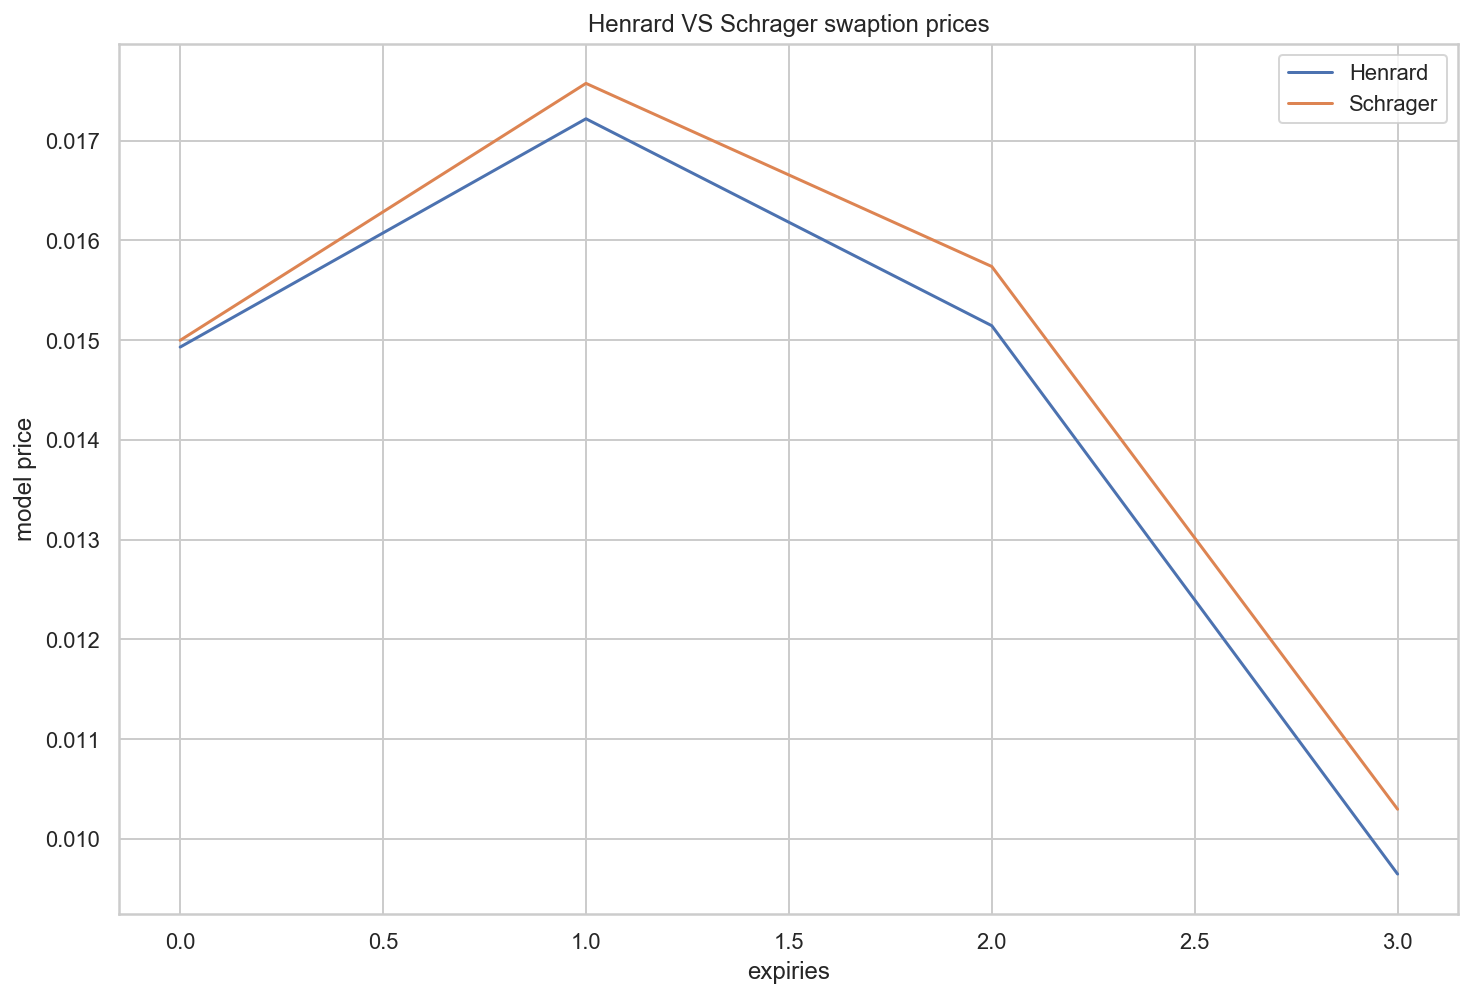

In [15]:
plt.plot(pricesH, label='Henrard')
plt.plot(pricesSch, label='Schrager')

plt.title('Henrard VS Schrager swaption prices');
plt.legend();plt.xlabel('expiries');plt.ylabel('model price');